In [2]:
import gc
import pandas as pd
import polars as pl
import math
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path

# スクリプトのあるディレクトリの絶対パスを取得
script_dir = str(Path('../scripts').resolve())

# sys.pathにスクリプトのディレクトリを追加
if script_dir not in sys.path:
    sys.path.insert(0, script_dir)

from preprocess import reduce_mem_usage, feature_engineering

In [3]:
train = reduce_mem_usage(pl.scan_parquet("../data/train.parquet")).collect()
train = feature_engineering(train).to_pandas()

In [3]:
train.head()

,Duration,Distance,PLong,PLatd,DLong,DLatd,Haversine,Pmonth,Pday,Phour,...,DDweek,Temp,Precip,Wind,Humid,Solar,Snow,GroundTemp,Dust,Usage_time
0,28,8480,37.530167,127.007439,37.535221,127.068398,5.404561,4,14,19,...,5,9.5,0.0,2.3,76.0,0.02,0.0,9.9,13.0,28
1,28,4610,37.512104,127.107780,37.531013,127.142365,3.704593,9,10,20,...,0,23.4,0.0,1.8,48.0,0.00,0.0,22.5,17.0,30
2,43,7470,37.557968,126.838287,37.557461,126.861458,2.043273,3,30,18,...,4,17.4,0.0,3.1,57.0,0.52,0.0,17.2,52.0,45
3,7,890,37.610523,127.059799,37.615299,127.064468,0.671691,9,24,20,...,0,17.6,0.0,1.4,57.0,0.00,0.0,16.2,10.0,8
4,45,5180,37.653015,127.046997,37.653015,127.046997,0.000000,8,15,20,...,2,28.4,0.0,1.5,69.0,0.01,0.0,26.9,0.0,48


In [4]:
train.columns

Index(['Duration', 'Distance', 'PLong', 'PLatd', 'DLong', 'DLatd', 'Haversine',
       'Pmonth', 'Pday', 'Phour', 'Pmin', 'PDweek', 'Dmonth', 'Dday', 'Dhour',
       'Dmin', 'DDweek', 'Temp', 'Precip', 'Wind', 'Humid', 'Solar', 'Snow',
       'GroundTemp', 'Dust', 'Usage_time'],
      dtype='object')

In [4]:
weather_features = [
    'Temp',
    'Precip',
    'Wind',
    'Humid',
    'Solar',
    'Snow',
    'GroundTemp',
    'Dust',
]

In [10]:
train[["Duration"] + weather_features].head()

,Duration,Temp,Precip,Wind,Humid,Solar,Snow,GroundTemp,Dust
0,28,9.5,0.0,2.3,76.0,0.02,0.0,9.9,13.0
1,28,23.4,0.0,1.8,48.0,0.00,0.0,22.5,17.0
2,43,17.4,0.0,3.1,57.0,0.52,0.0,17.2,52.0
3,7,17.6,0.0,1.4,57.0,0.00,0.0,16.2,10.0
4,45,28.4,0.0,1.5,69.0,0.01,0.0,26.9,0.0


In [5]:
df = train[["Duration"] + weather_features].sample(frac=0.01).copy()

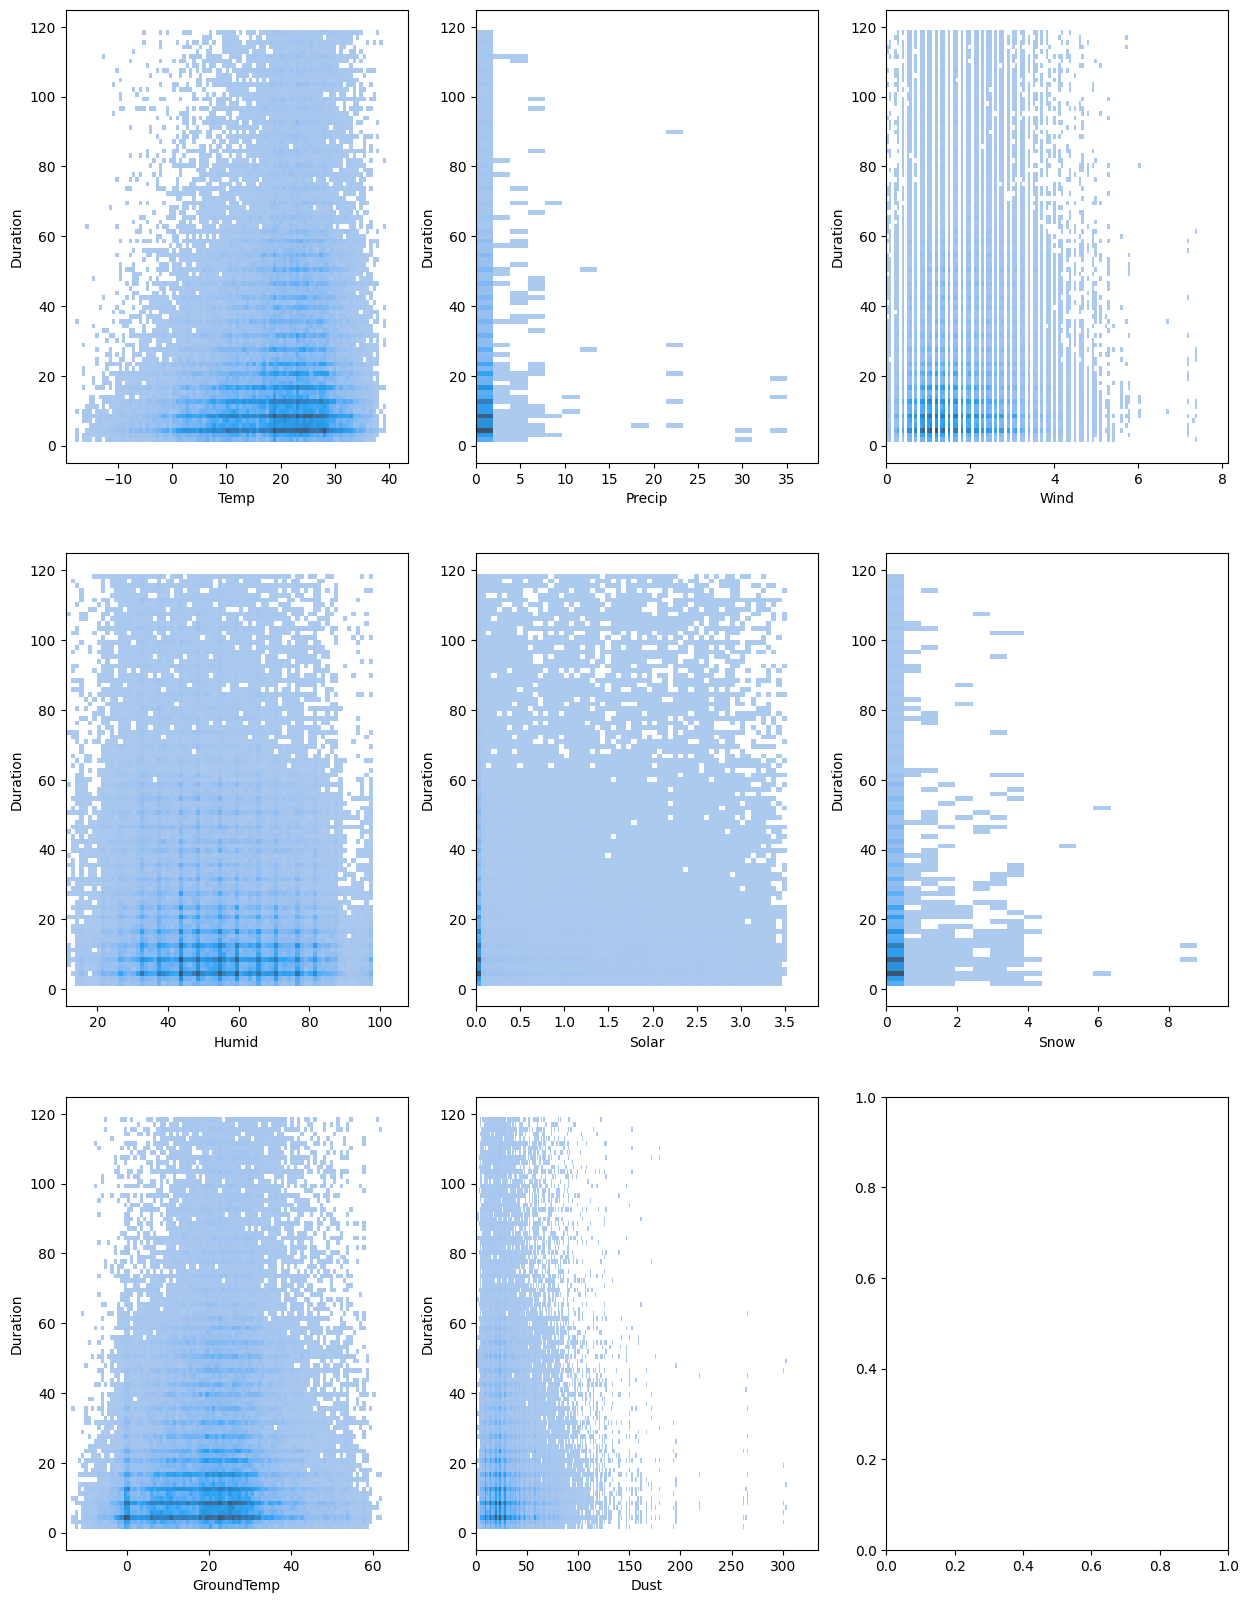

In [5]:
rows = math.ceil(len(weather_features) / 3)

fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(5 * rows, 20))

for d, ax in enumerate(axes.ravel()):
    column = df.columns[d+1]
    sns.histplot(data=df, x=column, y="Duration", ax=ax)
    ax.set(
        xlabel=df.columns[d+1],
        ylabel="Duration",
        xlim = (df.iloc[:, d+1].min() * 1.1, df.iloc[:, d+1].max() * 1.1)
    )
    if d + 1 == len(weather_features):
        break

fig.show()

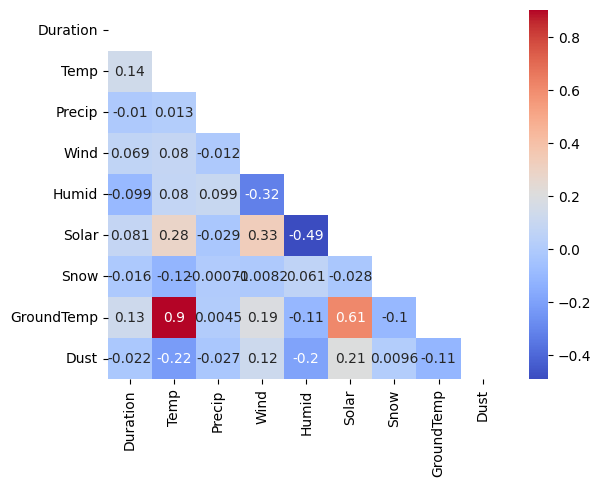

In [6]:
corr = df.corr()

# 上半分のマスクを作成
mask = np.triu(np.ones_like(corr, dtype=bool))

# ヒートマップを描画
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True)

plt.show()


In [10]:
from sklearn.manifold import TSNE

tsne_df = train[["Duration"] + weather_features].sample(frac=0.001).copy()

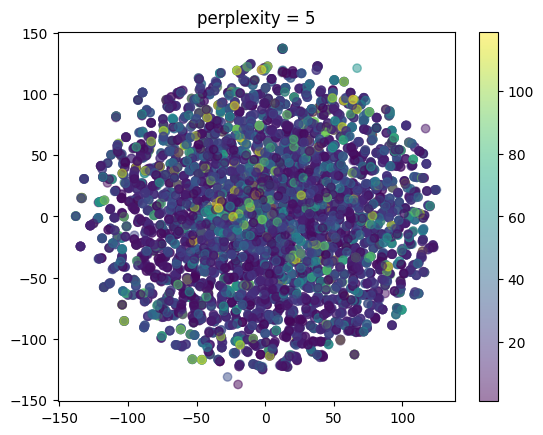

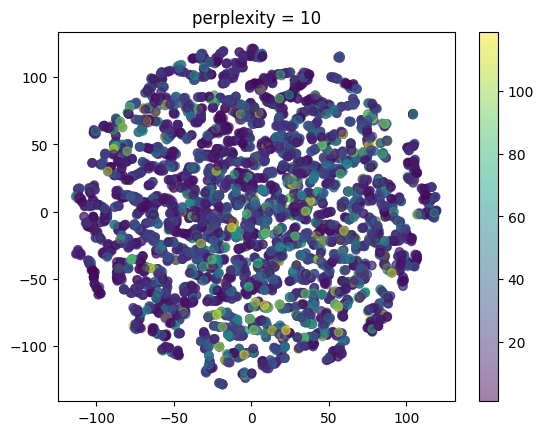

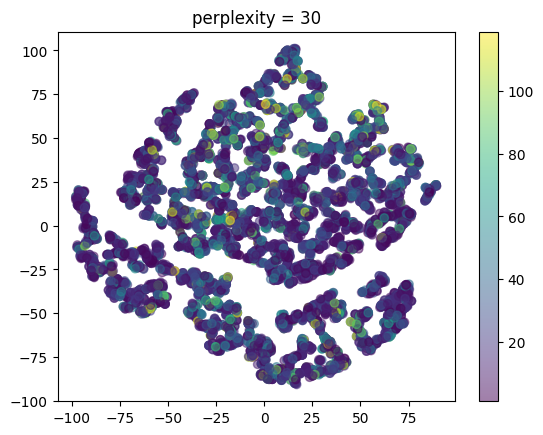

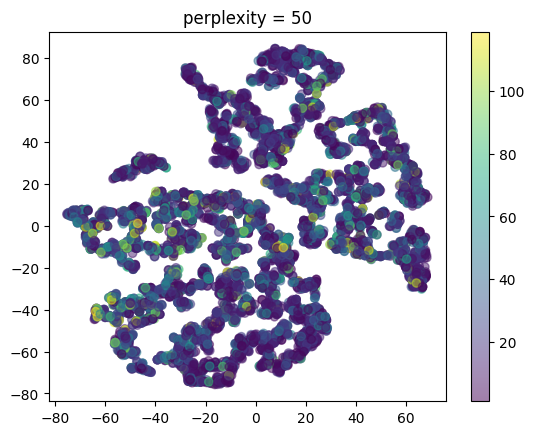

In [19]:
for perplexity in (5, 10, 30, 50):
    mapper = TSNE(perplexity=perplexity, init="random")
    embedding = mapper.fit_transform(tsne_df[["Temp", "Wind", "Humid", "Solar"]])
    title='perplexity = {0}'.format(perplexity)
    plt.title(title)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=tsne_df["Duration"], alpha=0.5)
    plt.colorbar()
    plt.show()

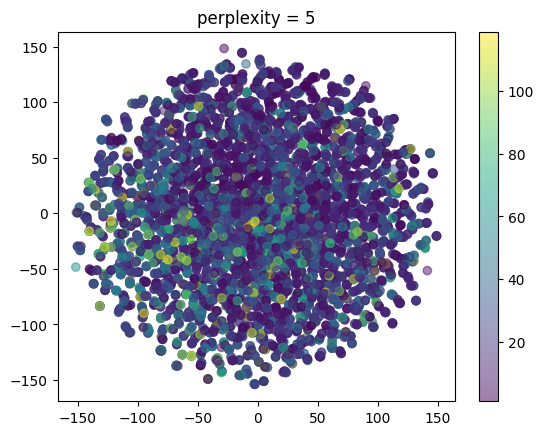

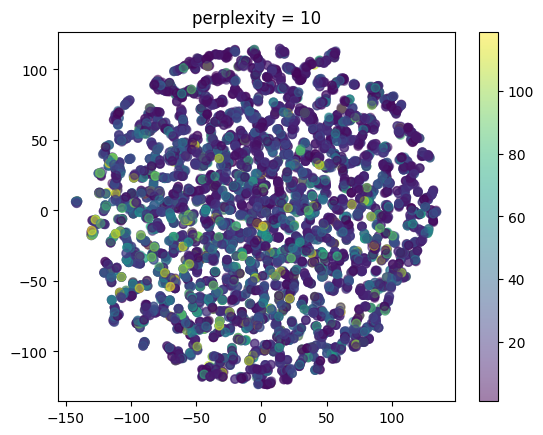

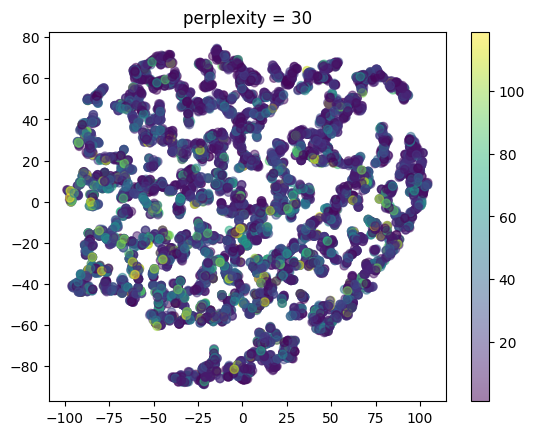

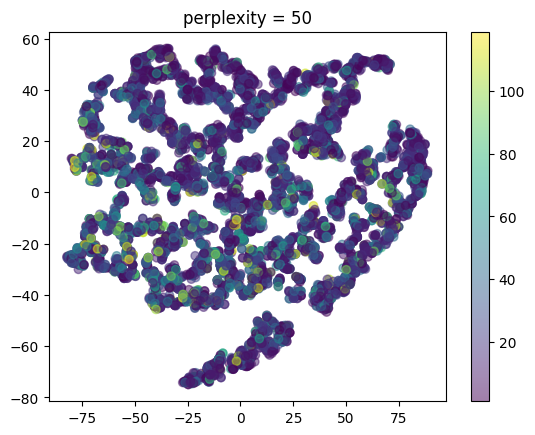

In [20]:
for perplexity in (5, 10, 30, 50):
    mapper = TSNE(perplexity=perplexity)
    embedding = mapper.fit_transform(tsne_df[["Temp", "Wind", "Humid", "Solar"]])
    title='perplexity = {0}'.format(perplexity)
    plt.title(title)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=tsne_df["Duration"], alpha=0.5)
    plt.colorbar()
    plt.show()

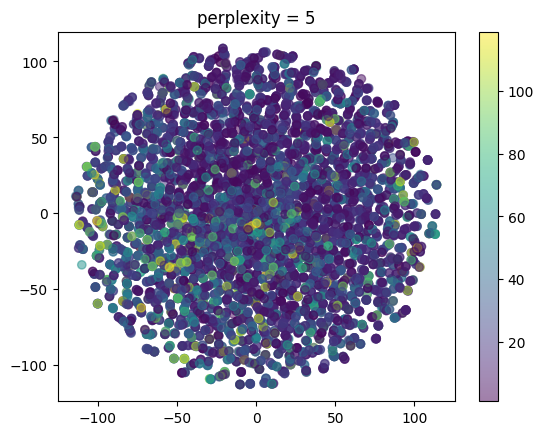

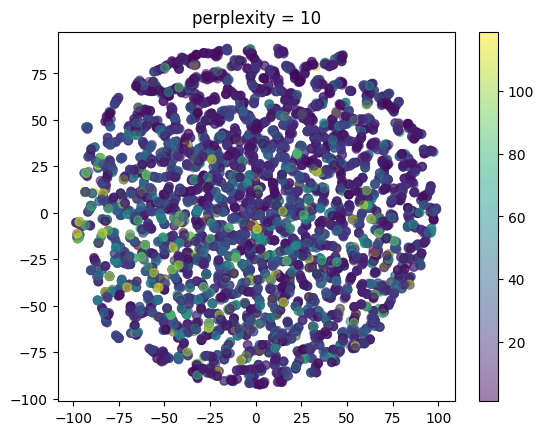

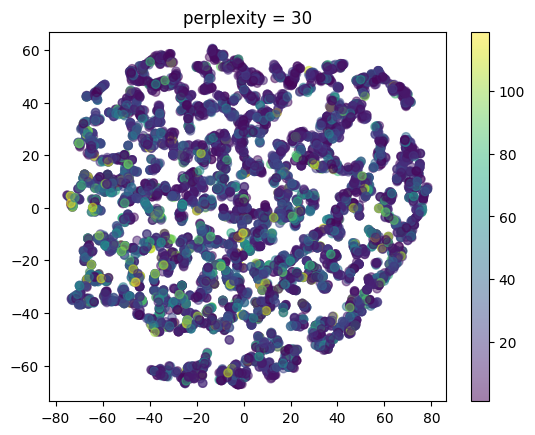

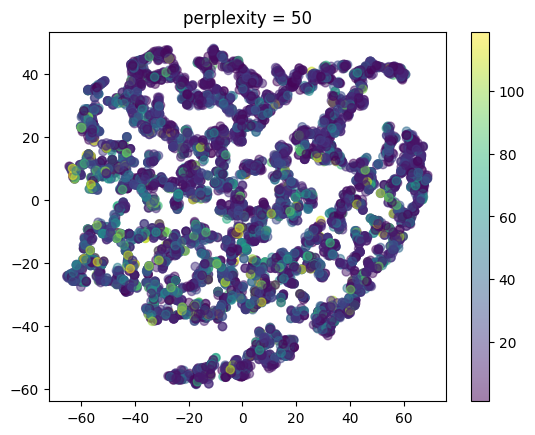

In [22]:
for perplexity in (5, 10, 30, 50):
    mapper = TSNE(perplexity=perplexity,early_exaggeration=30)
    embedding = mapper.fit_transform(tsne_df[["Temp", "Wind", "Humid", "Solar"]])
    title='perplexity = {0}'.format(perplexity)
    plt.title(title)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=tsne_df["Duration"], alpha=0.5)
    plt.colorbar()
    plt.show()

## Note
- t-SNEではDurationの大小で2次元ではクラスタリングできなさそう
- 一旦特徴量を作成してlgbmで評価